# Constantes

Tamanho da sequência utilizada, tamanho da janela, frequência de _cutoff_, tamanho de lote, etc.

In [1]:
SEQUENCE_SIZE=25
SEQUENCE_GAP=10
BATCH_SIZE=32
EPOCHS=200
LEARNING_RATE=0.001
SAMPLE_RATE = 1
CUTOFF_FREQUENCY = 0.01

# Preparação dos dados

Carregando os arquivos .csv que contém os dados de altura da lâmina e vazão.

## Altura

In [2]:
import pandas as pd

In [3]:
depth_df = pd.read_csv('data/water_depth_reservoir_Test1.csv')
display(depth_df)

,time (s),water depth (m),Unnamed: 2
0,0,0.45045,NaN
1,1,0.45070,NaN
2,2,0.45086,NaN
3,3,0.45096,NaN
4,4,0.45100,NaN
...,...,...,...
4313,4313,0.43703,NaN
4314,4314,0.43711,NaN
4315,4315,0.43720,NaN
4316,4316,0.43729,NaN


Devido à forma como o CSV está organizado, há uma coluna extra indesejada.

Para corrigir isso, podemos dropar essa coluna utilizando pandas.

In [4]:
depth_df = depth_df.drop(columns=[depth_df.columns[-1]])
display(depth_df)

,time (s),water depth (m)
0,0,0.45045
1,1,0.45070
2,2,0.45086
3,3,0.45096
4,4,0.45100
...,...,...
4313,4313,0.43703
4314,4314,0.43711
4315,4315,0.43720
4316,4316,0.43729


Ignorando coluna com o valor do tempo, pois a coluna de índice é equivalente.

In [5]:
depth_df = depth_df.drop(columns=[depth_df.columns[0]])
display(depth_df)

,water depth (m)
0,0.45045
1,0.45070
2,0.45086
3,0.45096
4,0.45100
...,...
4313,0.43703
4314,0.43711
4315,0.43720
4316,0.43729


## Vazão

In [6]:
discharge_df = pd.read_csv('data/discharge_inlet_Test1.csv')
display(discharge_df)

,time (s),inlet discharge (m3/s)
0,1,0.000630
1,1,0.000388
2,1,0.000203
3,1,0.000070
4,4,-0.000020
...,...,...
4313,4313,0.024713
4314,4314,0.024809
4315,4315,0.024889
4316,4316,0.024951


Na coluna indicando o tempo em segundos, o valor "1" está sendo repetido 4 vezes.

Tendo em vista que os valores da vazão mudaram para essas 4 entradas, vamos assumir que isso foi um erro de registro e que os valores são na realidade 0, 1, 2, ...

Essa mudança torna esse dataset consistente com o de altura carregado anteriormente.

Da mesma forma como fizemos anteriormente, podemos tratar a coluna de índices como nosso indicador de tempo.

In [7]:
discharge_df = discharge_df.drop(columns=[discharge_df.columns[0]])
display(discharge_df)

,inlet discharge (m3/s)
0,0.000630
1,0.000388
2,0.000203
3,0.000070
4,-0.000020
...,...
4313,0.024713
4314,0.024809
4315,0.024889
4316,0.024951


Podemos unir os dados em um só DF, o que facilita a preparação dos mesmos

In [8]:
unified_df = pd.concat([discharge_df, depth_df], axis=1)
display(unified_df)

,inlet discharge (m3/s),water depth (m)
0,0.000630,0.45045
1,0.000388,0.45070
2,0.000203,0.45086
3,0.000070,0.45096
4,-0.000020,0.45100
...,...,...
4313,0.024713,0.43703
4314,0.024809,0.43711
4315,0.024889,0.43720
4316,0.024951,0.43729


Remoção de ruídos

In [9]:
from scipy.signal import butter, filtfilt

smoothed_df = unified_df.copy()

original_discharge = smoothed_df['inlet discharge (m3/s)'].values
b, a = butter(N=6, Wn=CUTOFF_FREQUENCY/(0.5*SAMPLE_RATE), btype='low')
y = filtfilt(b, a, original_discharge)
smoothed_df['inlet discharge (m3/s)'] = y

original_depth = smoothed_df['water depth (m)'].values
b, a = butter(N=6, Wn=CUTOFF_FREQUENCY/(0.5*SAMPLE_RATE), btype='low')
y = filtfilt(b, a, original_depth)
smoothed_df['water depth (m)'] = y

Verificando resultado da remoção de ruído

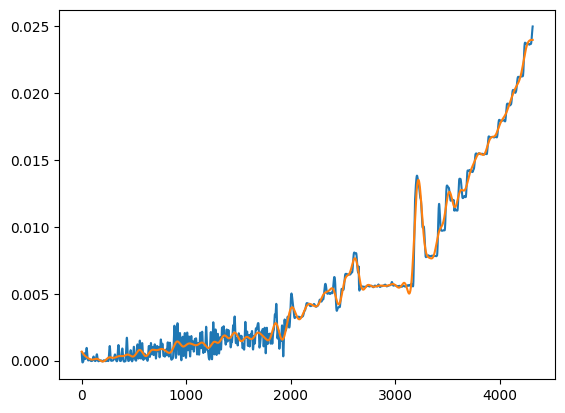

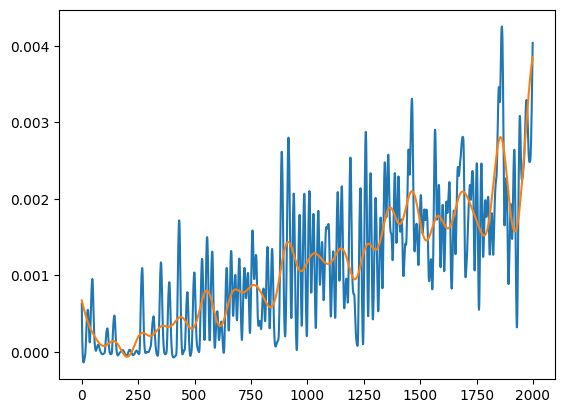

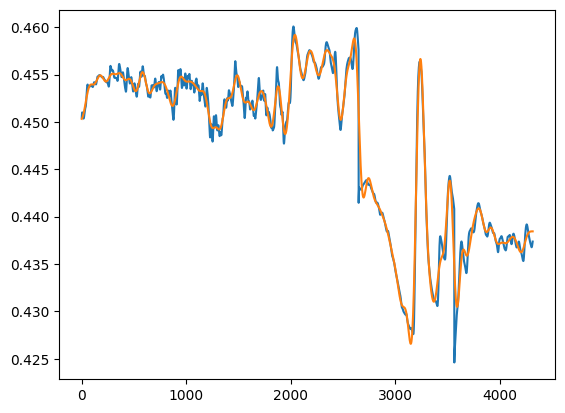

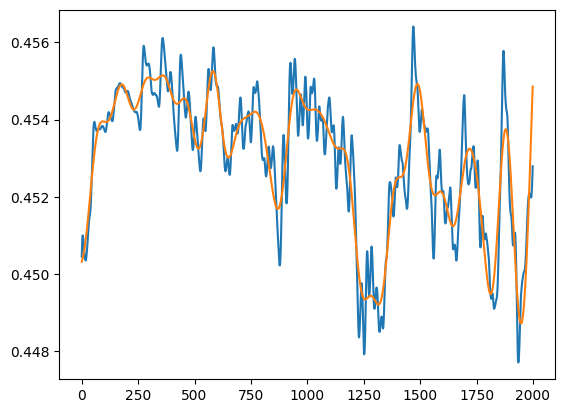

In [10]:
import matplotlib.pyplot as plt

plt.plot(unified_df['inlet discharge (m3/s)'])
plt.plot(smoothed_df['inlet discharge (m3/s)'])
plt.show()

plt.plot(unified_df['inlet discharge (m3/s)'].values[:2000])
plt.plot(smoothed_df['inlet discharge (m3/s)'].values[:2000])
plt.show()

plt.plot(unified_df['water depth (m)'])
plt.plot(smoothed_df['water depth (m)'])
plt.show()

plt.plot(unified_df['water depth (m)'].values[:2000])
plt.plot(smoothed_df['water depth (m)'].values[:2000])
plt.show()

Convertendo o DataFrame em array numpy para facilitar acesso.

In [11]:
unified = smoothed_df.to_numpy()

In [12]:
# Normalização
from sklearn.preprocessing import StandardScaler

unified_scaler = StandardScaler()
water_depth_scaler = StandardScaler()
inlet_discharge_scaler = StandardScaler()
water_depth_scaler.fit(unified[:, 1].reshape(-1, 1))
inlet_discharge_scaler.fit(unified[:, 0].reshape(-1, 1))
unified = unified_scaler.fit_transform(unified)

# Modelagem

## Estrutura dos dados de treinamento

Como iremos trabalhar com LSTM, precisamos definir um tamanho para nossas sequências. Visto que o conjunto de dados não é muito extenso, iremos utilizar sequências com uma determinada quantidade valores. Esse tamanho depende da constante SEQUENCE_SIZE.

In [13]:
# # Obtendo índices lower..upper
# i = 0
# lower = list()
# upper = list()
# while i + SEQUENCE_SIZE < len(unified):
#   lower.append(i)
#   upper.append(i + SEQUENCE_SIZE)
#   print(f"[{i}, {i + SEQUENCE_SIZE})")
#   i += SEQUENCE_GAP

Construindo sequência de inputs e outputs utilizadas pela rede.

No caso desse notebook:

- Input: Vazão
- Output: Altura da lâmina

Utilizando sequência para predizer último próximo valor da próxima: n -> 1

In [14]:
# import numpy as np

# number_of_sequences = len(lower)
# display("Quantidade de sequências", number_of_sequences)

# TRAINING_SIZE = int(number_of_sequences * 0.85)
# display("Quantidade de sequências de treinamento", TRAINING_SIZE)

# inputs = np.zeros((number_of_sequences, SEQUENCE_SIZE, 1))
# outputs = np.zeros((number_of_sequences, 1))
# for i in range(number_of_sequences):
#   inputs[i, :] = unified[lower[i]:upper[i], 1].reshape(SEQUENCE_SIZE, 1)
#   outputs[i, :] = unified[upper[i], 0]

# permuted_indices = np.random.permutation(number_of_sequences)
# inputs_train = inputs[permuted_indices[:TRAINING_SIZE]]
# outputs_train = outputs[permuted_indices[:TRAINING_SIZE]]
# inputs_test = inputs[permuted_indices[TRAINING_SIZE:]]
# outputs_test = outputs[permuted_indices[TRAINING_SIZE:]]
# display("Shapes", inputs_train.shape, outputs_train.shape, inputs_test.shape, outputs_test.shape)

Predizendo valores de uma sequência a partir de outra sequência: n -> n (seq2seq)

In [15]:
# import numpy as np

# number_of_sequences = len(lower)
# display("Quantidade de sequências", number_of_sequences)

# TRAINING_SIZE = int(number_of_sequences * 0.85)
# display("Quantidade de sequências de treinamento", TRAINING_SIZE)

# inputs = np.zeros((number_of_sequences, SEQUENCE_SIZE, 1))
# outputs = np.zeros((number_of_sequences, SEQUENCE_SIZE, 1))
# for i in range(number_of_sequences):
#   inputs[i, :] = unified[lower[i]:upper[i], 1].reshape(SEQUENCE_SIZE, 1)
#   outputs[i, :] = unified[lower[i]:upper[i], 0].reshape(SEQUENCE_SIZE, 1)

# permuted_indices = np.random.permutation(number_of_sequences)
# inputs_train = inputs[permuted_indices[:TRAINING_SIZE]]
# outputs_train = outputs[permuted_indices[:TRAINING_SIZE]]
# inputs_test = inputs[permuted_indices[TRAINING_SIZE:]]
# outputs_test = outputs[permuted_indices[TRAINING_SIZE:]]
# display("Shapes", inputs_train.shape, outputs_train.shape, inputs_test.shape, outputs_test.shape)

## Simplificada para Feedforward

In [16]:
import numpy as np

number_of_values = len(unified)
TRAINING_SIZE = int(number_of_values * 0.7)
display("Quantidade de dados para treinamento", TRAINING_SIZE)
VALIDATION_SIZE = int(number_of_values * 0.15)
display("Quantidade de dados para validação", VALIDATION_SIZE)
TEST_SIZE = int(number_of_values * 0.15)
display("Quantidade de dados para teste", TEST_SIZE)

permuted_idx = np.random.permutation(number_of_values)
train_idx = permuted_idx[:TRAINING_SIZE]
validation_idx = permuted_idx[TRAINING_SIZE:TRAINING_SIZE + VALIDATION_SIZE]
test_idx = permuted_idx[TRAINING_SIZE + VALIDATION_SIZE:]
train_x = unified[train_idx, 0].reshape(-1, 1)
train_y = unified[train_idx, 1].reshape(-1, 1)
validation_x = unified[validation_idx, 0].reshape(-1, 1)
validation_y = unified[validation_idx, 1].reshape(-1, 1)
test_x = unified[test_idx, 0].reshape(-1, 1)
test_y = unified[test_idx, 1].reshape(-1, 1)

'Quantidade de dados para treinamento'

3022

'Quantidade de dados para validação'

647

'Quantidade de dados para teste'

647

## Estrutura da rede neural e treinamento

Esse é uma das partes mais importantes, definir como será nossa rede neural.

Vamos começar com poucos neurônios, aumentando esse número caso a rede não consiga predizer com sucesso os valores da altura da lâmina.

In [33]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, TimeDistributed
from keras.optimizers import Adam

model = Sequential(name='water_depth_to_discharge')
model.add(InputLayer(input_shape=((1,)), name='input_layer'))
model.add(Dense(4, 'tanh'))
model.add(Dense(4, 'tanh', name='tanh'))
model.summary()
opt = Adam(learning_rate=LEARNING_RATE, amsgrad=True)
model.compile(loss='mse', optimizer=opt)

Model: "water_depth_to_discharge"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 4)                 8         
                                                                 
 tanh (Dense)                (None, 4)                 20        
                                                                 
Total params: 28 (112.00 Byte)
Trainable params: 28 (112.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

history = model.fit(
  train_x, train_y,
  epochs=EPOCHS, batch_size=BATCH_SIZE,
  shuffle=True,
  validation_data=(validation_x, validation_y),
  callbacks=[
    EarlyStopping(monitor='val_loss', patience=50),
    ModelCheckpoint('models/water_depth_to_discharge.h5', save_best_only=True, save_weights_only=True)
  ]
)
# Recuperando melhor modelo
model.load_weights('models/water_depth_to_discharge.h5')

Epoch 1/200
95/95 [==============================] - 1s 2ms/step - loss: 1.1635 - val_loss: 1.0640
Epoch 2/200
95/95 [==============================] - 0s 1ms/step - loss: 0.9602 - val_loss: 0.8922
Epoch 3/200
95/95 [==============================] - 0s 1ms/step - loss: 0.7981 - val_loss: 0.7486
Epoch 4/200
95/95 [==============================] - 0s 1ms/step - loss: 0.6666 - val_loss: 0.6359
Epoch 5/200
95/95 [==============================] - 0s 1ms/step - loss: 0.5747 - val_loss: 0.5690
Epoch 6/200
95/95 [==============================] - 0s 1ms/step - loss: 0.5249 - val_loss: 0.5363
Epoch 7/200
95/95 [==============================] - 0s 1ms/step - loss: 0.5002 - val_loss: 0.5186
Epoch 8/200
95/95 [==============================] - 0s 1ms/step - loss: 0.4871 - val_loss: 0.5101
Epoch 9/200
95/95 [==============================] - 0s 1ms/step - loss: 0.4793 - val_loss: 0.5042
Epoch 10/200
95/95 [==============================] - 0s 1ms/step - loss: 0.4744 - val_loss: 0.5005
Epoch 11/

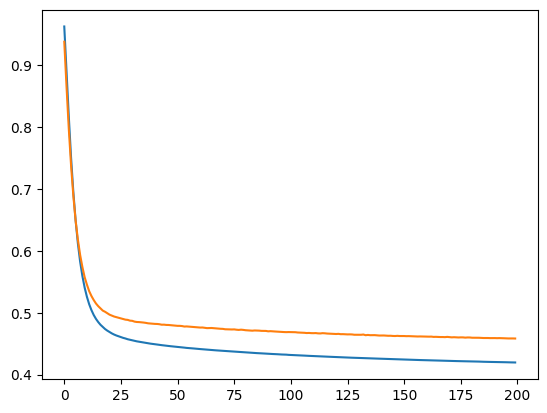

In [31]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.show()

# Resultados obtidos

Comparando predições para as sequências separadas para teste

21/21 [==============================] - 0s 662us/step


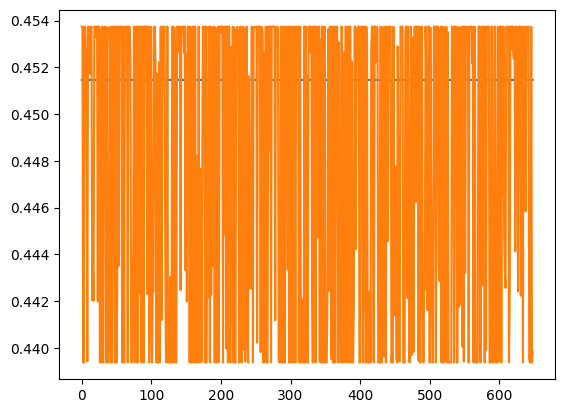

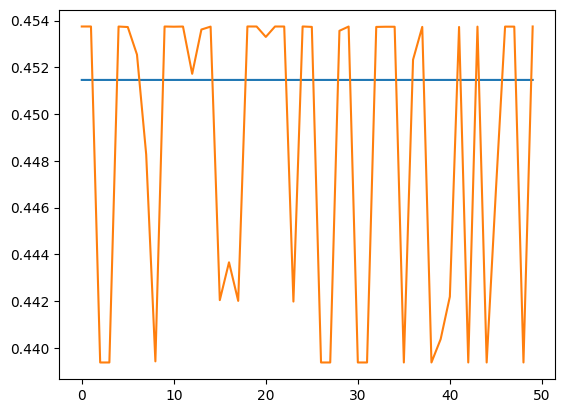

5.6883484e-05

In [32]:
from keras.losses import mean_squared_error

predictions = model.predict(test_x)
predictions = water_depth_scaler.inverse_transform(predictions)
test_y = water_depth_scaler.inverse_transform(test_y)

plt.plot(test_y, label='test_y')
plt.plot(predictions, label='predictions')
plt.show()

# Plot parts of the data
# 0-100
plt.plot(test_y[:50], label='test_y')
plt.plot(predictions[:50], label='predictions')
plt.show()

display(np.mean(mean_squared_error(test_y, predictions)))